In [1]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from random import sample
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tqdm

In [2]:
ONEGIN_FILE_PATH = "./onegin.txt"

# Data loading

In [186]:
if not os.path.exists(ONEGIN_FILE_PATH):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open(ONEGIN_FILE_PATH, 'r', encoding="utf-8") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '').replace('\n', '') for x in text if len(x.replace('\t\t', '').replace('\n', '')) > 0]

text[:30]

['I',
 '«Мой дядя самых честных правил,',
 'Когда не в шутку занемог,',
 'Он уважать себя заставил',
 'И лучше выдумать не мог.',
 'Его пример другим наука;',
 'Но, боже мой, какая скука',
 'С больным сидеть и день и ночь,',
 'Не отходя ни шагу прочь!',
 'Какое низкое коварство',
 'Полуживого забавлять,',
 'Ему подушки поправлять,',
 'Печально подносить лекарство,',
 'Вздыхать и думать про себя:',
 'Когда же черт возьмет тебя!»',
 'II',
 'Так думал молодой повеса,',
 'Летя в пыли на почтовых,',
 'Всевышней волею Зевеса',
 'Наследник всех своих родных. —',
 'Друзья Людмилы и Руслана!',
 'С героем моего романа',
 'Без предисловий, сей же час',
 'Позвольте познакомить вас:',
 'Онегин, добрый мой приятель,',
 'Родился на брегах Невы,',
 'Где, может быть, родились вы',
 'Или блистали, мой читатель;',
 'Там некогда гулял и я:',
 'Но вреден север для меня']

In [4]:
txt = []
MIN_LENGTH = 7
for i, s in enumerate(text):
    if len(s) > MIN_LENGTH:
        txt[-1].append(s.lower())
    else:
        txt.append([])
txt[::300]

[['«мой дядя самых честных правил,',
  'когда не в шутку занемог,',
  'он уважать себя заставил',
  'и лучше выдумать не мог.',
  'его пример другим наука;',
  'но, боже мой, какая скука',
  'с больным сидеть и день и ночь,',
  'не отходя ни шагу прочь!',
  'какое низкое коварство',
  'полуживого забавлять,',
  'ему подушки поправлять,',
  'печально подносить лекарство,',
  'вздыхать и думать про себя:',
  'когда же черт возьмет тебя!»'],
 ['татьяна вслушаться желает',
  'в беседы, в общий разговор;',
  'но всех в гостиной занимает',
  'такой бессвязный, пошлый вздор;',
  'всё в них так бледно, равнодушно;',
  'они клевещут даже скучно;',
  'в бесплодной сухости речей,',
  'расспросов, сплетен и вестей',
  'не вспыхнет мысли в целы сутки,',
  'хоть невзначай, хоть наобум',
  'не улыбнется томный ум,',
  'не дрогнет сердце, хоть для шутки.',
  'и даже глупости смешной',
  'в тебе не встретишь, свет пустой.']]

In [5]:
text_set = set()
for t in txt:
    for line in t:
        text_set.update(set(line))
text_set.update('\n')
tokens = sorted(set(text_set))
num_tokens = len(text_set)
num_tokens

83

In [6]:
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [7]:
txt = ['\n'.join(x) for x in txt]

In [8]:
class Poems(Dataset):
    def __init__(self, poems):
        self.poems = poems
    
    def __len__(self):
        return len(self.poems)
    
    def __getitem__(self, idx):
        return self.poems[idx]
    

def to_matrix(sentences, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of sentences into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, sentences))
    sentences_ix = np.zeros([len(sentences), max_len], dtype) + pad

    for i in range(len(sentences)):
        line_ix = [token_to_idx[c] for c in sentences[i]]
        sentences_ix[i, :len(line_ix)] = line_ix[:max_len]
        
    if not batch_first:
        sentences_ix = np.transpose(sentences_ix)

    return sentences_ix

poems = Poems(txt)

In [9]:
poems[0]

'«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать не мог.\nего пример другим наука;\nно, боже мой, какая скука\nс больным сидеть и день и ночь,\nне отходя ни шагу прочь!\nкакое низкое коварство\nполуживого забавлять,\nему подушки поправлять,\nпечально подносить лекарство,\nвздыхать и думать про себя:\nкогда же черт возьмет тебя!»'

# Learning

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

## vanilla RNN

In [11]:
from models import CharRNNCell, train_char_rnn

### vanilla RNN without dropout

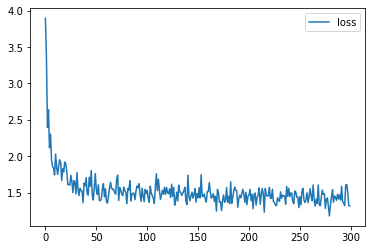

training...: 100%|███████████████████████████████████████████████████████████████████| 300/300 [15:40<00:00,  3.13s/it]


In [12]:
char_rnn = CharRNNCell(num_tokens=num_tokens)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, 
    patience=5,
    factor=0.5
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 300
history = []

train_char_rnn(
    char_rnn, 
    poems, 
    criterion, 
    opt, 
    scheduler, 
    history, 
    token_to_idx, 
    num_tokens, 
    device, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)
char_rnn.to('cpu')

### vanilla RNN with emb dropout

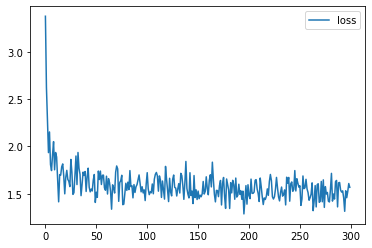

training...: 100%|███████████████████████████████████████████████████████████████████| 300/300 [17:00<00:00,  3.40s/it]


CharRNNCell(
  (emb): Embedding(83, 32)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (rnn): Linear(in_features=288, out_features=256, bias=True)
  (hid_to_logits): Linear(in_features=256, out_features=83, bias=True)
)

In [15]:
char_rnn_with_dropout = CharRNNCell(num_tokens=num_tokens, emb_dropout=0.3)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn_with_dropout.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, 
    patience=5,
    factor=0.5
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 300
history = []

train_char_rnn(
    char_rnn_with_dropout, 
    poems, 
    criterion, 
    opt, 
    scheduler, 
    history,
    token_to_idx, 
    num_tokens, 
    device, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)
char_rnn_with_dropout.to('cpu')

## LSTM

In [16]:
from models import LSTM, train_lstm

### LSTM without dropout

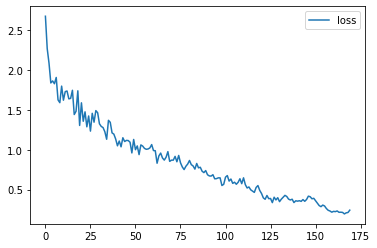

training...: 100%|███████████████████████████████████████████████████████████████████| 170/170 [05:05<00:00,  1.80s/it]


LSTM(
  (emb): Embedding(83, 32)
  (emb_dropout): Dropout(p=0, inplace=False)
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=83, bias=True)
)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm = LSTM(num_tokens=num_tokens, n_layers=2)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(lstm.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, 
    patience=5,
    factor=0.5
)
BATCH_SIZE = 32
EPOCHS = 170
history = []

train_lstm(
    lstm, 
    poems, 
    criterion, 
    opt, 
    scheduler, 
    history, 
    token_to_idx, 
    num_tokens, 
    device, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)
lstm.to('cpu')

### LSTM with emb and layer dropout

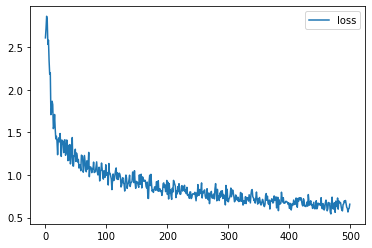

training...: 100%|███████████████████████████████████████████████████████████████████| 500/500 [18:28<00:00,  2.22s/it]


LSTM(
  (emb): Embedding(83, 32)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True, dropout=0.3)
  (hid_to_logits): Linear(in_features=256, out_features=83, bias=True)
)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_with_dropout = LSTM(num_tokens=num_tokens, n_layers=2, emb_dropout=0.3, lstm_dropout=0.3)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(lstm_with_dropout.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, 
    patience=5,
    factor=0.5
)
BATCH_SIZE = 32
EPOCHS = 500
history = []

train_lstm(
    lstm_with_dropout, 
    poems, 
    criterion, 
    opt, 
    scheduler, 
    history, 
    token_to_idx, 
    num_tokens, 
    device, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)
lstm_with_dropout.to('cpu')

### LSTM with emb, layer and weight dropout

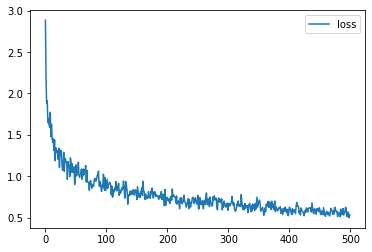

training...: 100%|███████████████████████████████████████████████████████████████████| 500/500 [18:24<00:00,  2.21s/it]


LSTM(
  (emb): Embedding(83, 32)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (lstm): WeightDrop(
    (module): LSTM(32, 256, num_layers=2, batch_first=True, dropout=0.3)
  )
  (hid_to_logits): Linear(in_features=256, out_features=83, bias=True)
)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_with_weight_dropout = LSTM(num_tokens=num_tokens, n_layers=2, emb_dropout=0.3, lstm_dropout=0.3, weight_dropout=0.3)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(lstm_with_weight_dropout.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, 
    patience=5,
    factor=0.5
)
BATCH_SIZE = 32
EPOCHS = 500
history = []

train_lstm(
    lstm_with_weight_dropout, 
    poems, 
    criterion, 
    opt, 
    scheduler, 
    history, 
    token_to_idx, 
    num_tokens, 
    device, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)
lstm_with_weight_dropout.to('cpu')

# Generating poems

## Generating vanilla RNN

In [20]:
def generate_sample_rnn(model, seed_phrase='я ', max_length=300, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, out = model(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = model(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [58]:
char_rnn.eval()
print(generate_sample_rnn(char_rnn, seed_phrase='я ', max_length=300, temperature=1.0))

я сной ластик все вачевный демний;
т лез-то ладите посчта
сбужеюбвстрательном;
на сужилковуталиколь;
мрегляжездутаядниньяныл;
овтелкавее висраши тьях,
почерьнепесторуконый;
призылавзамет, жеедим рыне
вло тон,  ошеди тели  злень?
ка траге сват кигерудь!
ичтять натичтотво назбыти
слевнет, чалинь разде


In [182]:
char_rnn_with_dropout.eval()
print(generate_sample_rnn(char_rnn_with_dropout, seed_phrase='я ', max_length=300, temperature=1.0))

я свишии, вотприхостолжина,
ка болод, свая и  отя ню
вет лкрочин ноко нобиоврилбы. на  ий ноливонь
потезкалссвосяндуедьель:
онакунсянью, ивневой се внай,
подратыльспошоме, вопусвых.
утриечтолацдитьяхдил, ханом,
ведабы, ннкени, здволи
вохотомлшао моо сноглал
мамнвевитящьшусьегуньясойт
ятных. при чисе


## Generating LSTM

In [23]:
def generate_sample_lstm(model, seed_phrase='я ', max_length=300, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hidden = model.initial_state(1, "cpu")
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hidden = model(x_sequence[:, i][None], hidden)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hidden = model(x_sequence[:, -1][None], hidden)
        # Be really careful here with the model output
        p_next = F.softmax(out[0] / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [24]:
lstm.eval()
print(generate_sample_lstm(lstm, seed_phrase='я ', max_length=300, temperature=1.0))

я плачу… едви ночь простились в ворадки,
хробно мой печали жаль.
сердечного не мог.
где ты в их устлетельном разроженье,
глубокий выгодно жены тревогу
остукла… законец наизур,
ты в нем собранье брави грехи,
писали в важный ум.
в них на дурственной разговор вручием;
прошую сердца всё равно:
томницу ф


In [25]:
lstm_with_dropout.eval()
print(generate_sample_lstm(lstm_with_dropout, seed_phrase='я ', max_length=300, temperature=1.0))

я знал к жизнь орна подъезжать мой,
как забаденный тут-вею
всех этих места, сквозь протик
в своей сердца твердя ль
она воспоминадий пиры:
и ждала татьяна понитал.
без элегине так умный
в гор так благословила ты;
еще не зная, как не свечай,
по вашем мерту; между тем
точь-только, милый, узором,
блажен


In [183]:
lstm_with_weight_dropout.eval()
print(generate_sample_lstm(lstm_with_weight_dropout, seed_phrase='я ', max_length=300, temperature=1.0))

я помню, где встает был рассеян,
ты юдешенно спор в год он
сезжала над хилем лугами
еще звук все полодный взор,
верная всех новых лод,
то чужь описать неграйне;
в двор. да вы, бывало, им отдам,
в очках имень возваженье?
приятный, и садь, то него
его долгонь ведал ей…..
но так мой зевал темли!
а эту 
